In [1]:
import os
import pathlib

# Set the working directory to be the parent of the cwd
os.chdir(pathlib.Path(os.getcwd()).parent)
cwd = os.getcwd()
print(cwd)

c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes


## Imports

In [ ]:
import gc
from inference import process_pred, process_true, convert_boxes_to_list_batch, apply_non_max_suppression_batch, compute_map
import matplotlib.pyplot as plt
import numpy as np
from loss import YOLOv1Loss
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import CustomDataset, train, eval
import wandb
import yaml

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


## Configurations

In [3]:
YOLO_PARAMS = {
    "S": 9, # Grid cells
    "B": 2, # Bounding boxes per each cell
    "C": 52 # Classes
}
OUTPUT_SIZE = YOLO_PARAMS["S"]*YOLO_PARAMS["S"] * (YOLO_PARAMS["B"]*5 + YOLO_PARAMS["C"])


convolution_list = [
    {
        "in_c": 3,
        "channels": [64],
        "kernels": [7],
        "strides": [2],
        "pool": [2, 2]
    },
    {
        "in_c": 64,
        "channels": [192],
        "kernels": [3],
        "strides": [1],
        "pool": [2, 2]
    },
    {
        "in_c": 192,
        "channels": [128, 256, 256, 512],
        "kernels": [1, 3, 1, 3],
        "strides": [1, 1, 1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 512,
        "channels": [256, 512]*4 + [512, 1024],
        "kernels": [1, 3]*4 + [1, 3],
        "strides": [1, 1]*4 + [1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 1024,
        "channels": [512, 1024]*2 + [1024, 1024],
        "kernels": [1, 3]*2 + [3, 3],
        "strides": [1, 1]*2 + [1, 2],
        "pool": False
    },
    {
        "in_c": 1024,
        "channels": [1024, 1024],
        "kernels": [3, 3],
        "strides": [1, 1],
        "pool": False
    },
]


mlp_dict = {
    "in_size": 1024,
    "hidden_sizes": [4096],
    "out_size": OUTPUT_SIZE
}

In [4]:
CONFIG = {
    "architecture"  : "yoloV1",
    "batch_size"    : 2,
    "epochs"        : 50,
    "lr"            : 5e-3,
    "optimizer"     : "SGD",
    "momentum"      : 0.9,
    "weight_decay"  : 0.0005,
    "p_dropout"     : 0.5,
    "scheduler"     : "ReduceLROnPlateau",
}

## Datasets and dataloaders

In [5]:
classes_path = os.path.join("configurations", "classes.yaml")
with open(classes_path, "r") as f:
    classes_yaml = yaml.safe_load(f)

CLASSES = classes_yaml["classes"]
NUM_CLASSES = len(CLASSES)

In [6]:
train_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "train", "images"),
    labels_dir=os.path.join(cwd, "data", "train", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=CONFIG["batch_size"],
    # num_workers=1,
    shuffle=True,
    pin_memory=True
)

development_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "development", "images"),
    labels_dir=os.path.join(cwd, "data", "development", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

development_loader = DataLoader(
    dataset=development_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=False
)

# TODO: Load the test data

### Check

In [7]:
for i, (batch, batch_label) in enumerate(train_loader):
    img = batch[0]
    label = batch_label[0]
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Batch: {batch.shape[0]}")
    break

Image shape: torch.Size([3, 416, 416])
Label shape: torch.Size([9, 9, 57])
Batch: 2


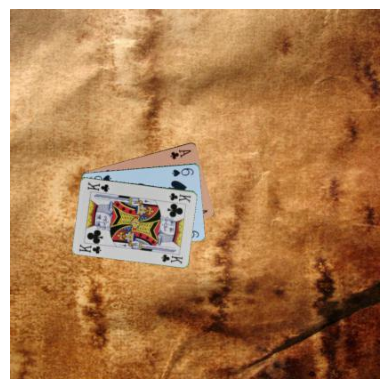

In [8]:
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

In [9]:
print(torch.argmax(label[...,5:], dim=-1))

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 36,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 44,  0,  0,  0,  0],
        [ 0, 44,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])


## Architecture

In [10]:
class ConvolutionBlock(nn.Module):

    def __init__(self, in_c, channels, kernels, strides, pool):
        super(ConvolutionBlock, self).__init__()

        convolutions = [nn.Conv2d(
            in_channels=in_c,
            out_channels=channels[0],
            kernel_size=kernels[0],
            stride=strides[0],
            padding=kernels[0]//2
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        if len(channels) > 1:
            for i in range(len(channels)-1):
                convolutions.append(nn.Conv2d(
                in_channels=channels[i],
                out_channels=channels[i+1],
                kernel_size=kernels[i+1],
                stride=strides[i+1],
                padding=kernels[i+1]//2
                ))
                convolutions.append(nn.LeakyReLU(negative_slope=0.1))
        
        if pool:
            convolutions.append(nn.MaxPool2d(
            kernel_size=pool[0],
            stride=pool[1]
            ))

        self.convolutions = nn.Sequential(*convolutions)


    def forward(self, x):
        return self.convolutions(x)

In [11]:
class Mlp(nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size):
        super(Mlp, self).__init__()

        fully_connected = [
            nn.Linear(
                in_features=in_size,
                out_features=hidden_sizes[0]
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        
        if len(hidden_sizes) > 1:
            for i in range(len(hidden_sizes)-1):
                fully_connected.append(nn.Linear(
                    in_features=hidden_sizes[i],
                    out_features=hidden_sizes[i+1]
                ))
                fully_connected.append(nn.LeakyReLU(negative_slope=0.1))

        fully_connected.append(nn.Linear(
            in_features=hidden_sizes[-1],
            out_features=out_size
        ))

        self.fully_connected = nn.Sequential(*fully_connected)
    
    
    def forward(self, x):
        return self.fully_connected(x)

In [12]:
class YoloV1(nn.Module):

    def __init__(self, yolo_params, convolution_blocks, mlp):
        super(YoloV1, self).__init__()

        self.params = yolo_params
        self.convolutions = nn.ModuleList(
            [
                ConvolutionBlock(
                    in_c=block["in_c"],
                    channels=block["channels"],
                    kernels=block["kernels"],
                    strides=block["strides"],
                    pool=block["pool"]
                ) for block in convolution_blocks
            ]
        )

        self.pool_flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.mlp = mlp
    
    
    def forward(self, x):
        for conv in self.convolutions:
            x = conv(x)
        x = self.pool_flatten(x)
        x = self.mlp(x)
        x = x.view(-1, self.params["S"], self.params["S"], self.params["B"]*5 + self.params["C"])

        return x

In [13]:
yolo_v1 = YoloV1(
    yolo_params=YOLO_PARAMS,
    convolution_blocks=convolution_list,
    mlp=Mlp(
        in_size=mlp_dict["in_size"],
        hidden_sizes= mlp_dict["hidden_sizes"],
        out_size=mlp_dict["out_size"]
    )
).to(DEVICE)

summary(yolo_v1, (3, 416, 416), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 208, 208]           9,472
         LeakyReLU-2         [-1, 64, 208, 208]               0
         MaxPool2d-3         [-1, 64, 104, 104]               0
  ConvolutionBlock-4         [-1, 64, 104, 104]               0
            Conv2d-5        [-1, 192, 104, 104]         110,784
         LeakyReLU-6        [-1, 192, 104, 104]               0
         MaxPool2d-7          [-1, 192, 52, 52]               0
  ConvolutionBlock-8          [-1, 192, 52, 52]               0
            Conv2d-9          [-1, 128, 52, 52]          24,704
        LeakyReLU-10          [-1, 128, 52, 52]               0
           Conv2d-11          [-1, 256, 52, 52]         295,168
        LeakyReLU-12          [-1, 256, 52, 52]               0
           Conv2d-13          [-1, 256, 52, 52]          65,792
        LeakyReLU-14          [-1, 256,

In [14]:
criterion = YOLOv1Loss(
    yolo_params=YOLO_PARAMS
)

optimizer = torch.optim.SGD(
    params=yolo_v1.parameters(),
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    threshold=0.1,
    factor=0.5,
    patience=5,
)

scaler = torch.amp.GradScaler(DEVICE)

## Test

- Add padding to images to get shape 448x448

In [15]:
pred = yolo_v1(batch.to(DEVICE))
true = batch_label.to(DEVICE)

S = YOLO_PARAMS["S"]
B = YOLO_PARAMS["B"]

In [ ]:
processed_preds = process_pred(pred, B)
print(processed_preds.shape)
boxes_batch, confidences_batch, classes_batch = convert_boxes_to_list_batch(processed_preds, S, B)
boxes_batch, confidences_batch, classes_batch = apply_non_max_suppression_batch(
    boxes_batch, confidences_batch, classes_batch, iou_threshold=0.5, confidence_threshold=0.01
)
assert len(boxes_batch[0]) == len(confidences_batch[0]) == len(classes_batch[0])
print(len(boxes_batch[0]))

(2, 9, 9, 11)
35


In [16]:
loss = train(
    model=yolo_v1,
    data_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=DEVICE
)

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

In [25]:
eval_loss, eval_map = eval(
    model=yolo_v1,
    data_loader=development_loader,
    criterion=criterion,
    device=DEVICE
)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

# Mount all info abou the run on wandb
wandb.watch(yolo_v1, log="all")

# Track metrics
best_eval_map = 0.0

num_epochs = CONFIG["epochs"]
for epoch in range(num_epochs):
    print("\nEpoch {}/{}".format(epoch+1, num_epochs))

    # Retrieve the learning rate
    curr_lr = optimizer.param_groups[0]["lr"]

    # Train the model
    train_loss = train(
        model=yolo_v1,
        data_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        device=DEVICE
    )
    print("Train loss\t: {:.04f}\t Learning rate : {:.04f}".format(train_loss, curr_lr))

    # Evaluate the model
    eval_loss, eval_map = eval(
        model=yolo_v1,
        data_loader=development_loader,
        criterion=criterion,
        device=DEVICE
    )
    print("Eval loss\t: {:.04f}\t Eval map : {:.04f}".format(eval_loss, eval_map))

    # Save the model if the eval map is the best so far
    if eval_map > best_eval_map:
        best_eval_map = eval_map
        torch.save(
            {
                "model_state_dict": yolo_v1.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "eval_map": eval_map,
                "epoch": epoch
            },
            os.path.join(cwd, "models", "yolo_v1.pth")
        )
    
    # Log metrics to wandb
    wandb.log({
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "eval_map": eval_map,
        "lr": curr_lr
    })

    # Update the learning rate with the scheduler
    scheduler.step(eval_loss)

## Detect cards